# Introdução

Esse caderno tem por objetivo a criação de um modelo básico de treinamento, utilizando o classificador [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), que faça a predição de homologação de arquivamentos de procedimentos enviados à 1A.CAM do MPF.

Esse modelo usará apenas os metadados dos procedimentos, sem fazer nenhum processamento textual.

O objetivo desse modelo é servir como um *baseline* de comparações para implementações futuras.


**Nota**: os dados desse modelo foram recuperados de procedimentos que tiveram suas deliberações realizadas após o dia 02/07/2018, data em que a nova composição tomou posse na 1A.CAM.

# Carga de dados e pré-processamento

Vamos fazer a carga dos dados e fazer um pré-processamento tradicional (remoção de atributos que não interessam, criação de variáveis categóricas etc.)

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd

from sklearn import metrics

In [3]:
PATH = "../data/"
df_original = pd.read_json(f'{PATH}/1A.CAM.homologacao-arquivamento.json')

In [4]:
len(df_original)

6216

In [5]:
df_original.columns

Index(['areaAtuacao', 'classe', 'dataAutuacao', 'dataEntrada', 'homologado',
       'id', 'identificadorPecaPromocao', 'itemCnmp', 'membroResponsavel',
       'municipio', 'prioritario', 'procedimento', 'quantidadeConversoes',
       'quantidadeProvidencias', 'textosProvidencias', 'urgente'],
      dtype='object')

In [6]:
df_original.describe()

,areaAtuacao,classe,homologado,id,identificadorPecaPromocao,itemCnmp,membroResponsavel,municipio,prioritario,quantidadeConversoes,quantidadeProvidencias,urgente
count,6.216000e+03,6216.000000,6216.000000,6.216000e+03,5.416000e+03,6.216000e+03,5416.000000,6216.000000,6216.000000,6216.000000,6216.000000,6216.000000
mean,3.240209e+02,2.530727,0.984878,6.728554e+07,7.826234e+07,2.407387e+04,38441.630908,2892.811776,0.006757,2.038288,7.249839,0.006918
std,2.536836e+04,0.923644,0.122049,1.323833e+07,6.341954e+06,2.100612e+05,34276.472876,1671.129519,0.081928,1.398246,8.758556,0.082891
min,1.000000e+00,1.000000,0.000000,2.842880e+06,5.580442e+07,2.000000e+00,752.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000e+00,2.000000,1.000000,6.400090e+07,7.311781e+07,1.521000e+03,13674.000000,1388.750000,0.000000,1.000000,3.000000,0.000000
50%,2.000000e+00,3.000000,1.000000,7.000453e+07,7.810596e+07,1.581500e+03,24990.000000,3078.000000,0.000000,2.000000,5.000000,0.000000
75%,2.000000e+00,3.000000,1.000000,7.543822e+07,8.461602e+07,1.893000e+03,53327.000000,4321.000000,0.000000,3.000000,9.000000,0.000000
max,2.000085e+06,61.000000,1.000000,8.756619e+07,8.810570e+07,2.007548e+06,127563.000000,5768.000000,1.000000,13.000000,161.000000,1.000000


In [7]:
len(df_original[df_original.identificadorPecaPromocao.isnull()])

800

In [8]:
df_work = df_original.copy()

In [9]:
# elementos com peça de promoção de arquivamento nulos não nos interessam
df_work.dropna(subset=['identificadorPecaPromocao'], inplace=True)
df_work.reset_index(drop=True, inplace=True)

In [10]:
len(df_work[df_work.identificadorPecaPromocao.isnull()])

0

In [11]:
# nessa primeira passada, essas colunas não nos interessam
removed_columns = ['id', 'procedimento', 'textosProvidencias', 'identificadorPecaPromocao']
df_work = df_work.drop(columns=removed_columns)
df_work.sample(10)

,areaAtuacao,classe,dataAutuacao,dataEntrada,homologado,itemCnmp,membroResponsavel,municipio,prioritario,quantidadeConversoes,quantidadeProvidencias,urgente
419,2,1,07-05-2018,12-07-2018,1,1507,87450.0,4716,0,1,2,0
5042,2,2,18-09-2015,22-02-2016,1,1861,17137.0,2211,0,0,5,0
3243,2,3,08-10-2014,04-04-2017,1,1857,27032.0,1214,0,2,2,0
778,2,2,13-10-2017,18-06-2018,1,3142,87528.0,2212,0,1,2,0
1371,2,3,23-10-2015,04-05-2018,1,1811,8592.0,3113,0,3,18,0
3679,5,3,09-10-2014,19-01-2017,1,3147,26701.0,1027,0,3,17,0
4609,2,2,14-03-2016,12-05-2016,1,1770,25849.0,3955,0,1,2,0
2088,2,2,15-05-2017,27-10-2017,1,1811,53330.0,3675,0,1,1,0
3745,2,3,01-07-2014,05-12-2016,1,1506,5990.0,4049,0,4,20,0
920,2,3,19-01-2017,07-06-2018,1,1766,64299.0,253,0,2,2,0


In [12]:
df_work.describe()

,areaAtuacao,classe,homologado,itemCnmp,membroResponsavel,municipio,prioritario,quantidadeConversoes,quantidadeProvidencias,urgente
count,5.416000e+03,5416.000000,5416.000000,5.416000e+03,5416.000000,5416.000000,5416.000000,5416.000000,5416.000000,5416.000000
mean,3.715170e+02,2.541728,0.984675,2.365916e+04,38441.630908,2898.190177,0.007570,2.070901,7.231905,0.007755
std,2.717745e+04,0.965573,0.122853,2.081188e+05,34276.472876,1662.738746,0.086685,1.406145,8.338839,0.087727
min,1.000000e+00,1.000000,0.000000,2.000000e+00,752.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000e+00,2.000000,1.000000,1.521000e+03,13674.000000,1438.000000,0.000000,1.000000,3.000000,0.000000
50%,2.000000e+00,3.000000,1.000000,1.585000e+03,24990.000000,3078.000000,0.000000,2.000000,5.000000,0.000000
75%,2.000000e+00,3.000000,1.000000,1.903000e+03,53327.000000,4335.000000,0.000000,3.000000,9.000000,0.000000
max,2.000085e+06,61.000000,1.000000,2.007548e+06,127563.000000,5768.000000,1.000000,13.000000,140.000000,1.000000


In [13]:
# tratando os nulos
df_work.fillna(-1, inplace=True)

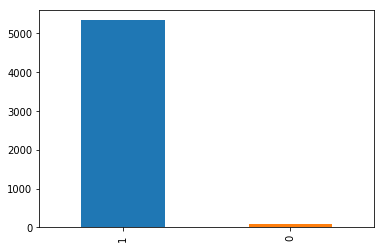

In [14]:
df_work['homologado'].value_counts().plot.bar()

### Classes desbalanceadas!!!

Conforme podemos ver acima, as classes desse problema são altamente desbalanceadas - apenas 1.46% do conjunto de dados representam procedimentos que não foram homologados.

Isso, muito provavelmente, causará problemas no treino do modelo. Mas, inicialmente, vamos ignorar isso e seguir com o nosso treino.

In [15]:
# conversão para datas
df_work['dataAutuacao'] = pd.to_datetime(df_work['dataAutuacao'],infer_datetime_format=True)
df_work['dataEntrada'] = pd.to_datetime(df_work['dataEntrada'],infer_datetime_format=True)

In [16]:
# vamos criar uma variável derivada, representando a quantidade de dias desde a autuação até a entrada
df_work['diasTranscorridos'] = 0
for index in range(len(df_work)):
    df_work.loc[index, 'diasTranscorridos'] =  (df_work.loc[index, 'dataEntrada'] - df_work.loc[index, 'dataAutuacao']).days

In [17]:
df_work.sample(10)

,areaAtuacao,classe,dataAutuacao,dataEntrada,homologado,itemCnmp,membroResponsavel,municipio,prioritario,quantidadeConversoes,quantidadeProvidencias,urgente,diasTranscorridos
2128,2,3,2016-03-30,2017-10-25,1,1868,11016.0,5459,0,3,5,0,574
549,2,2,2018-01-24,2018-07-06,1,1713,6830.0,3113,0,1,9,0,163
2816,2,3,2011-04-02,2017-06-14,1,1560,31451.0,1492,0,5,22,0,2265
759,2,3,2016-11-07,2018-06-13,1,2004410,20982.0,810,0,2,13,0,583
1563,2,2,2018-12-01,2018-04-02,1,2830,11904.0,810,0,1,7,0,-243
733,2,3,2015-03-12,2018-06-26,1,1556,127531.0,151,0,2,4,0,1202
4036,2,3,2015-08-26,2016-10-21,1,1521,53328.0,170,0,1,6,0,422
5032,2,3,2013-01-08,2016-02-12,1,1852,31575.0,5039,0,2,6,0,1130
3937,2,2,2015-11-02,2016-11-04,1,1521,23774.0,4828,0,2,8,0,368
3673,3,2,2016-10-25,2016-12-16,1,1581,87450.0,4960,0,1,3,0,52


In [18]:
removed_columns = ['homologado', 'dataEntrada', 'dataAutuacao']
features = [c for c in df_work.columns if c not in removed_columns]

model = RandomForestClassifier(random_state=42)
model.fit(df_work[features], df_work['homologado'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [19]:
model.score(df_work[features], df_work['homologado'])

0.9987075332348597

In [20]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(df_work, random_state=42)
train.shape, valid.shape

((4062, 13), (1354, 13))

In [21]:
model.fit(train[features], train['homologado'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [22]:
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_score():
    print('Accuracy score:', accuracy_score(train['homologado'], train_preds), accuracy_score(valid['homologado'], valid_preds))
    print('Precision score: ', format(precision_score(valid['homologado'], valid_preds)))
    print('Recall score: ', format(recall_score(valid['homologado'], valid_preds)))
    print('F1 score: ', format(f1_score(valid['homologado'], valid_preds)))

print_score()

Accuracy score: 0.9975381585425899 0.983751846381093
Precision score:  0.983751846381093
Recall score:  1.0
F1 score:  0.9918093819806404


### Primeira avaliação

Embora não tenha ocorrido overfitting no treinamento e o *score* final tenha sido alto, cabe utilizar uma outra medida para assegurar a qualidade do modelo. Vamos utilizar a ** *matriz de confusão* **.



In [25]:
from sklearn.metrics import confusion_matrix

confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   22],
       [   0, 1332]])

In [26]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   22,    0, 1332])

In [27]:
len(valid[valid['homologado']==1]), len(valid[valid['homologado']==0])

(1332, 22)

Ao utilizar o ravel(), temos uma saída do tipo (tn, fp, fn, tp). De onde vemos que:


- tivemos 0 tn - *true negative*; ou seja, o modelo não conseguiu acertar nenhum dos que não tiveram o arquivamento homologado;
- tivemos 22 fp - *false positive*; 22 que não tiveram o arquivamento homologado e o modelo classificou como homologado;
- tivemos 0 fn - *false negative*; foram homologados e o modelo marcou como não homologados;
- tivemos 1322 tp - *true positive*; foram homologados e o modelo marcou corretamente.

Logo, apesar da acurácia do modelo aparentar ser muito boa (98% no validation set), o **modelo não sabe lidar com os não arquivamentos** - não acertou nenhum dos que realmente não foram homologados. Ou seja dos 22 que não foram homologados, o modelo errou todos.

Fica claro que somente essas features não ajudam na descoberta - o texto da íntegra é, segundo a área negocial, realmente o mais importante.

Vamos continuar avaliando esse modelo.

## Feature importances

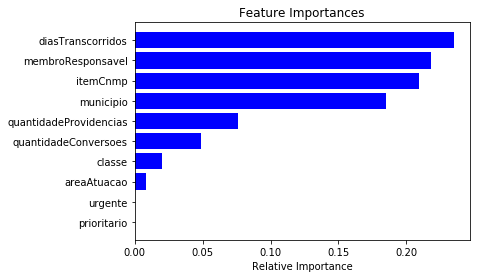

In [28]:
import matplotlib.pyplot as plt

def plot_fi(feature_importances, size=None):
    feature_importances = model.feature_importances_
    
    if not size:
        size = len(feature_importances)
    
    indices = np.argsort(feature_importances[0:size])
    
    plt.title('Feature Importances')
    plt.barh(range(size), feature_importances[indices], color='b', align='center')
    plt.yticks(range(size), [features[i] for i in indices if i < size])
    plt.xlabel('Relative Importance')
    plt.show()
    
plot_fi(model.feature_importances_)

O modelo está dando muita importância ao município que, considerando o bom senso e um pouco de domínio negocial, não faz sentido - o município não deveria interferir.

Lembrar: criar uma coluna para cada uma das listas de palavras-chaves, indicando ausência ou presença

In [29]:
# Vou retirar as colunas com poucas importância
removed_columns = ['homologado', 'dataEntrada', 'dataAutuacao', 'urgente', 'prioritario']
features = [c for c in df_work.columns if c not in removed_columns]

model = RandomForestClassifier(random_state=42)

model.fit(train[features], train['homologado'])

train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9975381585425899 0.983751846381093
Precision score:  0.983751846381093
Recall score:  1.0
F1 score:  0.9918093819806404


In [30]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   22,    0, 1332])

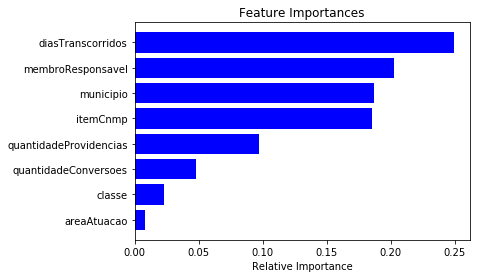

In [31]:
plot_fi(model.feature_importances_)

Com as novas features, retirando a urgente e a prioritário, não houve melhorias.

Vou retirar a coluna município, pois, ao meu ver, ela não nos parece adequada - e o modelo continua dando muita importância a ela.

In [32]:
removed_columns.append('municipio')
removed_columns

features = [c for c in df_work.columns if c not in removed_columns]

model.fit(train[features], train['homologado'])

train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9975381585425899 0.983751846381093
Precision score:  0.983751846381093
Recall score:  1.0
F1 score:  0.9918093819806404


In [33]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   22,    0, 1332])

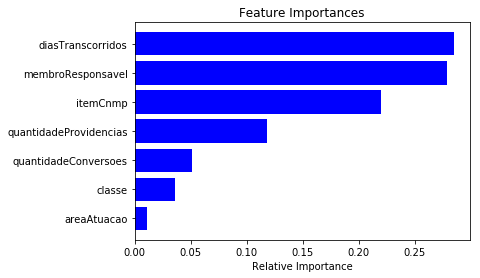

In [34]:
plot_fi(model.feature_importances_)

Ao retirar a coluna município, o desempenho se manteve.

Vamos criar um modelo ainda mais simples, apenas com as features cuja importância seja maior que 5%.

In [35]:
model = RandomForestClassifier(random_state=42)

important_features = ['membroResponsavel', 'diasTranscorridos', 'itemCnmp', 'quantidadeProvidencias', 'quantidadeConversoes']
model.fit(train[important_features], train['homologado'])

train_preds = model.predict(train[important_features])
valid_preds = model.predict(valid[important_features])

print_score()

Accuracy score: 0.9977843426883308 0.981536189069424
Precision score:  0.9837157660991858
Recall score:  0.9977477477477478
F1 score:  0.9906820723071188


In [36]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   22,    3, 1329])

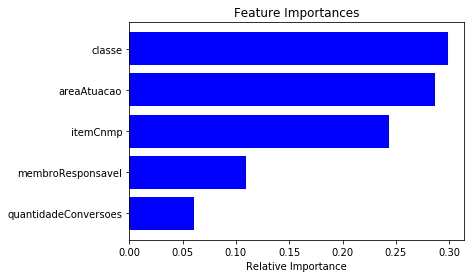

In [37]:
plot_fi(model.feature_importances_)

Somente com as features importantes acima, o desempenho se piorou (caiu a acurácia e métricas relacionadas, e ainda tivemos 3 false negativas - homologados marcados como não homologados). 

Interessante notar que a variável diasTranscorridos desapereceu da lista de importâncias.

Vamos fazer mais um teste, apenas com as top-3 features

In [38]:
important_features = ['classe', 'areaAtuacao', 'itemCnmp']

model = RandomForestClassifier(random_state=42)
model.fit(train[important_features], train['homologado'])

train_preds = model.predict(train[important_features])
valid_preds = model.predict(valid[important_features])

print_score()

Accuracy score: 0.9867060561299852 0.98301329394387
Precision score:  0.983739837398374
Recall score:  0.9992492492492493
F1 score:  0.9914338919925514


In [39]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   22,    1, 1331])

Com o modelo mais simples, a acurácia foi melhor do que o anterior, mas ainda há falsos positivos. 

Fica claro que não sabe lidar com os não homologados.

Vamos passar a considerar o texto das providências.

## Considerando as providências realizadas

In [40]:
df_work = df_original.copy()

df_work.dropna(subset=['identificadorPecaPromocao'], inplace=True)
df_work.reset_index(drop=True, inplace=True)

df_work['dataAutuacao'] = pd.to_datetime(df_work['dataAutuacao'],infer_datetime_format=True)
df_work['dataEntrada'] = pd.to_datetime(df_work['dataEntrada'],infer_datetime_format=True)

df_work['diasTranscorridos'] = 0
for index in range(len(df_work)):
    df_work.loc[index, 'diasTranscorridos'] =  (df_work.loc[index, 'dataEntrada'] - df_work.loc[index, 'dataAutuacao']).days

removed_columns = ['id', 'procedimento', 'identificadorPecaPromocao', 'prioritario', 'urgente', 'dataAutuacao', 'dataEntrada']
df_work = df_work.drop(columns=removed_columns)
df_work.fillna(-1, inplace=True)

    
df_work.sample(10)

,areaAtuacao,classe,homologado,itemCnmp,membroResponsavel,municipio,quantidadeConversoes,quantidadeProvidencias,textosProvidencias,diasTranscorridos
3142,2,3,1,1503,87454.0,693,4,11,"Converta-se em Inquérito Civil(IC).,Analisar A...",982
4354,2,3,1,1521,53295.0,2919,3,7,"Converta-se em Inquérito Civil(IC).,Oficie-se....",386
260,2,2,1,1543,127538.0,5510,3,2,Prorroga-se o prazo de finalização do Procedim...,245
5028,2,2,1,1788,53327.0,1681,1,3,"Oficie-se.,Converta-se em Procedimento Prepara...",174
1430,2,3,1,1521,9394.0,3476,3,12,"Despacho Simplificado,Converta-se em Inquérito...",655
1653,2,3,1,1921,23277.0,4964,3,3,"Converta-se em Inquérito Civil(IC).,Prorroga-s...",325
801,2,3,1,1556,127502.0,577,2,5,"Converta-se em Inquérito Civil(IC).,Oficie-se....",675
4920,2,2,1,3126,20443.0,4838,1,1,Converta-se em Procedimento Preparatório(PP).,78
2244,2,3,1,1585,64343.0,5050,2,4,"Análise do arquivamento,Converta-se em Inquéri...",1249
1845,2,2,1,1727,8592.0,3113,1,3,"Oficie-se.,Encaminhe-se o AA para que seja sob...",121


In [41]:
listaProvidencias = []
for index in range(len(df_work)):
    for s in str(df_work['textosProvidencias'][index]).strip().lower().split(','):
        listaProvidencias.append(s)

listaProvidencias = set(listaProvidencias)
listaProvidencias.remove('análise do arquivamento')
listaProvidencias.remove('analisar arquivamento')

In [42]:
df_work = pd.concat([df_work, pd.get_dummies(sorted(list(listaProvidencias)), drop_first=True)], axis=1)

In [43]:
for index in range(len(df_work)):
    for s in str(df_work.textosProvidencias[index]).strip().split(','):
        df_work.at[index, s.lower()] = 1

In [44]:
df_work.head()

,areaAtuacao,classe,homologado,itemCnmp,membroResponsavel,municipio,quantidadeConversoes,quantidadeProvidencias,textosProvidencias,diasTranscorridos,...,reautue-se,recomende-se.,redistribua-se.,requisite-se perícia à ccr/mpf.,sobrestar no setor.,solicitar instauração de inquérito judicial,vistoria,analisar arquivamento,,análise do arquivamento
0,2,3,1,3078,53306.0,2733,1,3,"Despacho Simplificado,Converta-se em Inquérito...",279,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1,2,3,1,1515,4575.0,4108,5,17,"Encaminhe-se o auto.,Analisar Arquivamento,Ofi...",1947,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN
2,2,3,1,1542,17795.0,5296,2,4,"Converta-se em Inquérito Civil(IC).,Oficie-se....",367,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
3,2,3,1,3058,5262.0,3573,3,9,"Converta-se em Inquérito Civil(IC).,Analisar A...",1030,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN
4,2,3,1,1521,53306.0,2561,1,2,"Converta-se em Inquérito Civil(IC).,Cumpra-se.",552,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [45]:
df_work.fillna(-1, inplace=True)

In [46]:
removed_columns = ['homologado', 'textosProvidencias']
features = [c for c in df_work.columns if c not in removed_columns]

In [47]:
train, valid = train_test_split(df_work, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(train[features], train['homologado'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [48]:
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9977843426883308 0.983751846381093
Precision score:  0.983751846381093
Recall score:  1.0
F1 score:  0.9918093819806404


In [50]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   22,    0, 1332])

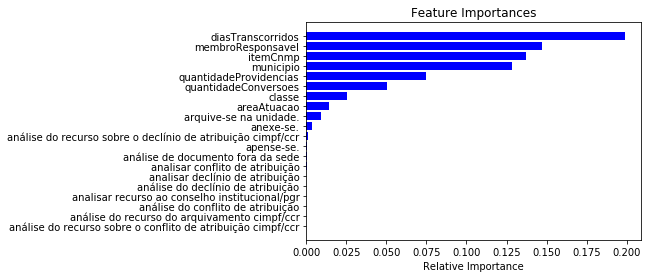

In [51]:
plot_fi(model.feature_importances_, 20)

O uso dos textos das providências não aumentou a precisão do modelo (e elas também não foram features importantes).

Agora vamos efetivamente utilizar o texto das íntegras.